In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

#detecting license plate on the vehicle
plateCascade = cv2.CascadeClassifier('indian_license_plate.xml')


def plate_detect(img):
    plateImg = img.copy()
    roi = img.copy()
    plateRect = plateCascade.detectMultiScale(plateImg,scaleFactor = 1.2, minNeighbors = 7)
    
    for (x,y,w,h) in plateRect:
        roi_ = roi[y:y+h, x:x+w, :]
        plate_part = roi[y:y+h, x:x+w, :]
        cv2.rectangle(plateImg,(x+2,y),(x+w-3, y+h-5),(0,255,0),3)
    return plateImg, plate_part

 The following tasks will be performed in the above code:

    First of all, the important libraries are imported like NumPy, cv2, and matplotlib.
    Then the CascadeClassifier is used for detecting the vehicle’s number plate region. Cascading classifiers are used to detect a particular feature or a region inside an image. The feature here is the Number Plate of a Vehicle.
    Cascading classifiers are trained with several hundred “positive” sample views of a particular object and arbitrary “negative” images of the same size. After the classifier is trained it can be applied to a region of an image and detect the object.
    Then there is a function called plate_detect() to detect the vehicle’s number plate and mark it with a green rectangle on it then crop that image’s plate region and return it to another function.
    This function will be called from another function called display_img().



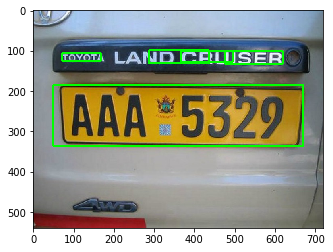

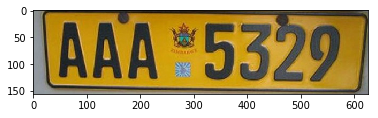

In [6]:
def display_img(img):
    img_ = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img_)
    plt.show()
    
inputImg = cv2.imread('Registration-Plates.jpg')
inpImg, plate = plate_detect(inputImg)
display_img(inpImg)
display_img(plate)

 The following tasks will be performed in the above code:

    The above code is used to display the image.
    There is a function called display_img() which will take an image as a parameter and convert it from BGR color code to RGB Color code then will display it on screen using matplotlib.
    Then we will read an image called car.jpg and call the function plate_detect() and then display the car image and the cropped plate image.

In [7]:
def find_contours(dimensions, img) :

    #finding all contours in the image using 
    #retrieval mode: RETR_TREE
    #contour approximation method: CHAIN_APPROX_SIMPLE
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    #Approx dimensions of the contours
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    #Check largest 15 contours for license plate character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ci = cv2.imread('contours.png')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        #detecting contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        #checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) 
            char_copy = np.zeros((44,24))
            #extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            cv2.rectangle(ci, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ci, cmap='gray')
            char = cv2.subtract(255, char)
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0
            img_res.append(char_copy) # List that stores the character's binary image (unsorted)
            
    #return characters on ascending order with respect to the x-coordinate
            
    plt.show()
    #arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

In [8]:
def segment_characters(image) :
    #pre-processing cropped image of plate
    #threshold: convert to pure b&w with sharpe edges
    #erod: increasing the backgroung black
    #dilate: increasing the char white
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    #estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.show()
    cv2.imwrite('contours.png',img_binary_lp)

    #getting contours
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list
    
    
    # char = segment_characters(plate)
    
    for i in range(10):
      plt.subplot(1, 10, i+1)
      plt.imshow(char[i], cmap='gray')
      plt.axis('off')

Now this part is the Preprocessing of the Image i.e (Number Plate of Vehicle) 

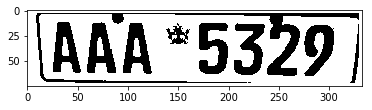

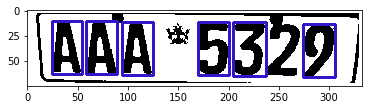

In [9]:
char = segment_characters(plate)

In [9]:
import keras.backend as K
import tensorflow as tf
from sklearn.metrics import f1_score 
from tensorflow.keras import optimizers
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D
train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)
path = 'images'
train_generator = train_datagen.flow_from_directory(
        path+'/train',  
        target_size=(28,28), 
        batch_size=1,
        class_mode='sparse')

validation_generator = train_datagen.flow_from_directory(
        path+'/val',  
        target_size=(28,28), class_mode='sparse')

        

#It is the harmonic mean of precision and recall
#Output range is [0, 1]
#Works for both multi-class and multi-label classification
def f1score(y, y_pred):
    return f1_score(y, tf.math.argmax(y_pred, axis=1), average='micro') 

def custom_f1score(y, y_pred):
    return tf.py_function(f1score, (y, y_pred), tf.double)

Found 864 images belonging to 36 classes.
Found 216 images belonging to 36 classes.


Now it’s time to get the training dataset and validation dataset and create a model. We have generated our data that is the preprocessed images dataset from previous steps. 

In [10]:
K.clear_session()
model = Sequential()
model.add(Conv2D(16, (22,22), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (16,16), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (8,8), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (4,4), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(lr=0.0001), metrics=[custom_f1score])

class stop_training_callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_custom_f1score') > 0.99):
            self.model.stop_training = True
            

batch_size = 1
callbacks = [stop_training_callback()]
model.fit_generator(
      train_generator,
      steps_per_epoch = train_generator.samples // batch_size,
      validation_data = validation_generator, 
      epochs = 80, verbose=1, callbacks=callbacks)

C:\Users\Warumwa\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
C:\Users\Warumwa\AppData\Local\Temp\ipykernel_19928\2443498001.py:23: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


Epoch 1/80
864/864 [==============================] - 56s 63ms/step - loss: 3.0257 - custom_f1score: 0.1829 - val_loss: 1.6955 - val_custom_f1score: 0.5491
Epoch 2/80
864/864 [==============================] - 56s 65ms/step - loss: 1.2559 - custom_f1score: 0.6088 - val_loss: 0.6696 - val_custom_f1score: 0.8170
Epoch 3/80
864/864 [==============================] - 51s 59ms/step - loss: 0.6166 - custom_f1score: 0.8160 - val_loss: 0.3834 - val_custom_f1score: 0.8690
Epoch 4/80
864/864 [==============================] - 51s 59ms/step - loss: 0.4175 - custom_f1score: 0.8565 - val_loss: 0.2045 - val_custom_f1score: 0.9449
Epoch 5/80
864/864 [==============================] - 51s 59ms/step - loss: 0.2769 - custom_f1score: 0.9005 - val_loss: 0.1899 - val_custom_f1score: 0.9405
Epoch 6/80
864/864 [==============================] - 52s 60ms/step - loss: 0.2003 - custom_f1score: 0.9456 - val_loss: 0.3221 - val_custom_f1score: 0.9286
Epoch 7/80
864/864 [==============================] - 47s 54ms/s

In [26]:

def fix_dimension(img):
    new_img = np.zeros((28,28,3))
    for i in range(3):
        new_img[:,:,i] = img
    return new_img
  
def show_results():
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(char): 
        img_ = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3)
        y_ = model.predict(img)
        # character = dic[y_] #
        output.append(y_) 
        
    plate_number = ''.join(output)
    
    return plate_number

final_plate = show_results()
print(final_plate)

TypeError: sequence item 0: expected str instance, numpy.ndarray found

In [ ]:
import requests
import xmltodict
import json


# def get_vehicle_info(plate_number):
#     r = requests.get("http://www.regcheck.org.uk/api/reg.asmx/CheckIndia?RegistrationNumber={0}&username=mama".format(str(plate_number)))
#     data = xmltodict.parse(r.content)
#     jdata = json.dumps(data)
#     df = json.loads(jdata)
#     df1 = json.loads(df['Vehicle']['vehicleJson'])
#     return df1
    
# get_vehicle_info(final_plate)

model.save('license_plate_character.pkl')

In [1]:
# from preprocess import plate_detect, find_contours, segment_characters, f1score, custom_f1score, fix_dimension
import matplotlib.pyplot as plt
from tensorflow.keras import models
import tensorflow.keras.backend as K
import cv2
import numpy as np
import warnings
import requests
import xmltodict
import json
warnings.filterwarnings("ignore")

# import all preprocess functions

model = models.load_model('model/license_plate_character.h5', custom_objects={
                      'custom_f1score': custom_f1score})


def fix_dimension(img):
    new_img = np.zeros((28, 28, 3))
    for i in range(3):
        new_img[:, :, i] = img
    return new_img

def show_results(pl_char):
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i, c in enumerate(characters):
        dic[i] = c

    output = []
    for i, ch in enumerate(pl_char):
        img_ = cv2.resize(ch, (28, 28), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1, 28, 28, 3)
        y_ = model.predict_classes(img)[0]
        character = dic[y_]
        output.append(character)

    plate_number = ''.join(output)

    return plate_number


def runVideo():
    # license_video.mp4 have to be yours, I haven't uploaded for privacy concern
    cam = cv2.VideoCapture(0)
    if cam.isOpened() == False:
        print("Video not imported")

    plate_list = []
    info_list = []
    while(cam.isOpened()):
        ret, frame = cam.read()
        cv2.imshow('frame', frame)
        
        if ret == True:
            car_plate, plate_img = plate_detect(frame)
            #cv2.imshow("License Video", car_plate)
            
            if len(plate_img) > 0:
                plate_char = segment_characters(plate_img)
                # print(plate_char)
                number_plate = show_results(plate_char)
                print(number_plate)
                # if number_plate not in plate_list:
                #     final_result = None
                #     if final_result != None:
                #         plate_list.append(number_plate)
                #         info_list.append(final_result)
                #         break
                    # print(final_result)

            if cv2.waitKey(1) == 27:
                break
        else:
            break

    cam.release()
    cv2.destroyAllWindows()
    return info_list[0]

# def get_vehicle_info(plate_number):
#     r = requests.get(
#         "http://www.regcheck.org.uk/api/reg.asmx/CheckIndia?RegistrationNumber={0}&username=tom123".format(str(plate_number)))
#     # data = xmltodict.parse(r.content)
#     data=r.json()
#     print(data)
#     # jdata = json.dumps(data)
#     # df = json.loads(jdata)
#     df1 = json.loads(r['Vehicle']['vehicleJson'])
#     return df1

# print(final_plate)   
# resu=get_vehicle_info(final_plate)
# print(resu)
resulting=runVideo()
# print(resulting)

NameError: name 'plateCascade' is not defined

In [ ]:
import cv2
import tensorflow as tf
from sklearn.metrics import f1_score
import requests
import xmltodict 
import json
import numpy as np
import re
import warnings
warnings.filterwarnings("ignore")

plateCascade = cv2.CascadeClassifier('indian_license_plate.xml')


def plate_detect(img):
    plateImg = img.copy()
    roi = img.copy()
    plate_part = np.array([])
    plateRect = plateCascade.detectMultiScale(
        plateImg, scaleFactor=1.2, minNeighbors=7)
    for (x, y, w, h) in plateRect:
        roi_ = roi[y:y+h, x:x+w, :]
        plate_part = roi[y:y+h, x:x+w, :]
        cv2.rectangle(plateImg, (x+2, y), (x+w-3, y+h-5), (0, 255, 0), 3)
    # print(type(roi))
    # print(roi.shape)
    return plateImg, plate_part


def find_contours(dimensions, img):

    # finding all contours in the image using
    # retrieval mode: RETR_TREE
    # contour approximation method: CHAIN_APPROX_SIMPLE
    cntrs, _ = cv2.findContours(
        img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Approx dimensions of the contours
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]

    # Check largest 15 contours for license plate character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]

    ci = cv2.imread('contour.png')

    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs:
        # detecting contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)

        # checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height:
            x_cntr_list.append(intX)
            char_copy = np.zeros((44, 24))
            # extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            cv2.rectangle(ci, (intX, intY), (intWidth+intX,
                          intY+intHeight), (50, 21, 200), 2)
            #plt.imshow(ci, cmap='gray')
            char = cv2.subtract(255, char)
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0
            # List that stores the character's binary image (unsorted)
            img_res.append(char_copy)

    # return characters on ascending order with respect to the x-coordinate

    # plt.show()
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        # stores character images according to their index
        img_res_copy.append(img_res[idx])
    img_res = np.array(img_res_copy)

    return img_res


def segment_characters(image):

    # pre-processing cropped image of plate
    # threshold: convert to pure b&w with sharpe edges
    # erod: increasing the backgroung black
    # dilate: increasing the char white
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(
        img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3, 3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3, 3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]
    img_binary_lp[0:3, :] = 255
    img_binary_lp[:, 0:3] = 255
    img_binary_lp[72:75, :] = 255
    img_binary_lp[:, 330:333] = 255

    # estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                  LP_WIDTH/2,
                  LP_HEIGHT/10,
                  2*LP_HEIGHT/3]
    #plt.imshow(img_binary_lp, cmap='gray')
    # plt.show()
    cv2.imwrite('contour.png', img_binary_lp)

    # getting contours
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list


def f1score(y, y_pred):
    return f1_score(y, tf.math.argmax(y_pred, axis=1), average='micro')


def custom_f1score(y, y_pred):
    return tf.py_function(f1score, (y, y_pred), tf.double)


def fix_dimension(img):
    new_img = np.zeros((28, 28, 3))
    for i in range(3):
        new_img[:, :, i] = img
    return new_img


def get_vehicle_info(plate_number):
    r = requests.get(
        "http://www.regcheck.org.uk/api/reg.asmx/CheckIndia?RegistrationNumber={0}&username=tom123".format(str(plate_number)))
    data = xmltodict.parse(r.content)
    jdata = json.dumps(data)
    df = json.loads(jdata)
    df1 = json.loads(df['Vehicle']['vehicleJson'])
    return df1


def plate_info(numberPlate):
    pattern = '^[A-Z]{2}[0-9]{1,2}([A-Z])?([A-Z]*)?[0-9]{4}$'
    if len(numberPlate) > 10:
        numberPlate = numberPlate[-10:]
        return get_vehicle_info(numberPlate)
#     else:
#         return get_vehicle_info(numberPlate)
    elif re.match(pattern, numberPlate) != None:
        return get_vehicle_info(numberPlate)
    else:
        return None

In [1]:
# from preprocess import plate_detect, find_contours, segment_characters, f1score, custom_f1score, fix_dimension
import matplotlib.pyplot as plt
from tensorflow.keras import models
import tensorflow.keras.backend as K
import cv2
import numpy as np
import warnings
import requests
import xmltodict
import json
warnings.filterwarnings("ignore")

# import all preprocess functions

plateCascade = cv2.CascadeClassifier('indian_license_plate.xml')


def plate_detect(img):
    plateImg = img.copy()
    roi = img.copy()
    plate_part = np.array([])
    plateRect = plateCascade.detectMultiScale(
        plateImg, scaleFactor=1.2, minNeighbors=7)
    for (x, y, w, h) in plateRect:
        roi_ = roi[y:y+h, x:x+w, :]
        plate_part = roi[y:y+h, x:x+w, :]
        cv2.rectangle(plateImg, (x+2, y), (x+w-3, y+h-5), (0, 255, 0), 3)
    # print(type(roi))
    # print(roi.shape)
    return plateImg, plate_part


def find_contours(dimensions, img):

    # finding all contours in the image using
    # retrieval mode: RETR_TREE
    # contour approximation method: CHAIN_APPROX_SIMPLE
    cntrs, _ = cv2.findContours(
        img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Approx dimensions of the contours
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]

    # Check largest 15 contours for license plate character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]

    ci = cv2.imread('contour.png')

    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs:
        # detecting contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)

        # checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height:
            x_cntr_list.append(intX)
            char_copy = np.zeros((44, 24))
            # extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            cv2.rectangle(ci, (intX, intY), (intWidth+intX,
                          intY+intHeight), (50, 21, 200), 2)
            #plt.imshow(ci, cmap='gray')
            char = cv2.subtract(255, char)
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0
            # List that stores the character's binary image (unsorted)
            img_res.append(char_copy)

    # return characters on ascending order with respect to the x-coordinate

    # plt.show()
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        # stores character images according to their index
        img_res_copy.append(img_res[idx])
    img_res = np.array(img_res_copy)

    return img_res


def segment_characters(image):

    # pre-processing cropped image of plate
    # threshold: convert to pure b&w with sharpe edges
    # erod: increasing the backgroung black
    # dilate: increasing the char white
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(
        img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3, 3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3, 3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]
    img_binary_lp[0:3, :] = 255
    img_binary_lp[:, 0:3] = 255
    img_binary_lp[72:75, :] = 255
    img_binary_lp[:, 330:333] = 255

    # estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                  LP_WIDTH/2,
                  LP_HEIGHT/10,
                  2*LP_HEIGHT/3]
    #plt.imshow(img_binary_lp, cmap='gray')
    # plt.show()
    cv2.imwrite('contour.png', img_binary_lp)

    # getting contours
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list


def f1score(y, y_pred):
    return f1_score(y, tf.math.argmax(y_pred, axis=1), average='micro')


def custom_f1score(y, y_pred):
    return tf.py_function(f1score, (y, y_pred), tf.double)


def fix_dimension(img):
    new_img = np.zeros((28, 28, 3))
    for i in range(3):
        new_img[:, :, i] = img
    return new_img


model = models.load_model('model/license_plate_character.h5', custom_objects={
                      'custom_f1score': custom_f1score})


def fix_dimension(img):
    new_img = np.zeros((28, 28, 3))
    for i in range(3):
        new_img[:, :, i] = img
    return new_img

def show_results(pl_char):
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i, c in enumerate(characters):
        dic[i] = c

    output = []
    for i, ch in enumerate(pl_char):
        img_ = cv2.resize(ch, (28, 28), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1, 28, 28, 3)
        y_ = model.predict_classes(img)[0]
        character = dic[y_]
        output.append(character)

    plate_number = ''.join(output)

    return plate_number





def runVideo(vpath):
    # license_video.mp4 have to be yours, I haven't uploaded for privacy concern
    cam = cv2.VideoCapture(vpath)
    if cam.isOpened() == False:
        print("Video not imported")

    plate_list = []
    info_list = []
    while(cam.isOpened()):
        ret, frame = cam.read()
        if ret == True:
            car_plate, plate_img = plate_detect(frame)
            #cv2.imshow("License Video", car_plate)
            if len(plate_img) > 0:
                plate_char = segment_characters(plate_img)
                # print(plate_char)
                number_plate = show_results(plate_char)
                if number_plate not in plate_list:
                    final_result = number_plate
                    print(final_result)
                    if final_result != None:
                        plate_list.append(number_plate)
                        info_list.append(final_result)
                        break
                    # print(final_result)

            if cv2.waitKey(1) == 27:
                break
        else:
            break

    cam.release()
    cv2.destroyAllWindows()
    return info_list[0]

# def get_vehicle_info(plate_number):
#     r = requests.get(
#         "http://www.regcheck.org.uk/api/reg.asmx/CheckIndia?RegistrationNumber={0}&username=tom123".format(str(plate_number)))
#     # data = xmltodict.parse(r.content)
#     data=r.json()
#     print(data)
#     # jdata = json.dumps(data)
#     # df = json.loads(jdata)
#     df1 = json.loads(r['Vehicle']['vehicleJson'])
#     return df1

# print(final_plate)   
# resu=get_vehicle_info(final_plate)
# print(resu)
resulting=runVideo('./test.mp4')
# print(resulting)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
H1111111QJ
